In [8]:
#Fausto Vega
#Optimal Control Final Project
using ECOS, Convex, LinearAlgebra
using SatelliteDynamics
using COSMO
using Mosek
using MosekTools

In [9]:
function skewmatrix(x) #create the skew symmetric matrix from a vector input
    S = [0 -x[3] x[2]; x[3] 0 -x[1]; -x[2] x[1] 0]
    return S
end

skewmatrix (generic function with 1 method)

In [10]:
α = 5e-4 #mass dynamics constant

0.0005

In [11]:
#For MARS 
#omega for mars
omega = [2.53e-5 0 6.62e-5]

#mars gravity
g = vec([-3.71 0 0])

3-element Vector{Float64}:
 -3.71
  0.0
  0.0

In [12]:
nx = 7 #number of states [position velocity mass]
nu = 4 #number of controls on acceleration
nd = 7 #number of affine variables

7

In [13]:
N = 95 #number of knot points works

95

In [14]:
dt = 0.5 #time step

0.5

In [15]:
#Create A Matrix
A = [zeros(3,3) I zeros(3); -(skewmatrix(omega))^2 -2*skewmatrix(omega) zeros(3); zeros(7)']

#Create B Matrix
B_original = [zeros(3,3); I]

B = [B_original zeros(6);zeros(3)' -α]

#Affine term
d = [zeros(3,3); I; zeros(3)']*g

#Create Ã
Ã = [A B I; zeros(nu,nx+nu+nd); zeros(nd,nx+nu+nd)]

18×18 Matrix{Float64}:
  0.0          0.0          0.0         …  1.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  1.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  1.0  0.0  0.0  0.0  0.0
  4.38244e-9  -0.0         -1.67486e-9     0.0  0.0  0.0  1.0  0.0  0.0  0.0
 -0.0          5.02253e-9  -0.0            0.0  0.0  0.0  0.0  1.0  0.0  0.0
 -1.67486e-9  -0.0          6.4009e-10  …  0.0  0.0  0.0  0.0  0.0  1.0  0.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  1.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0         …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0          0.0          0.0            0.0  0.0  

In [16]:
#change from continous to discrete 
H = exp(dt*Ã) 

Ad = H[1:nx, 1:nx] 
Bd = H[1:nx,(nx+1):(nx+4)]
Dd = H[1:nx, (nx+5):end]

7×7 Matrix{Float64}:
  0.5           1.73173e-15  -3.48929e-11  …   2.75833e-6  1.30848e-11  0.0
 -1.73173e-15   0.5           6.61823e-16      0.125       1.05417e-6   0.0
 -3.48929e-11  -6.61823e-16   0.5             -1.05417e-6  0.125        0.0
  5.47805e-10   1.38538e-14  -2.09357e-10      1.655e-5    1.04679e-10  0.0
 -1.38538e-14   6.27816e-10   5.29458e-15      0.5         6.325e-6     0.0
 -2.09357e-10  -5.29458e-15   8.00112e-11  …  -6.325e-6    0.5          0.0
  0.0           0.0           0.0              0.0         0.0          0.5

In [17]:
mf = 300 #final mass in kg (not used in optimization)
m0 = 2000 #intial mass in kg

#Landing state
x_goal = [0, 0, 0, 0, 0, 0, log(mf)] #x,y,z, vx,vy,vz

7-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 5.703782474656201

In [18]:
theta = 70 * pi/180 #thrust pointing angle
Vmax = 90 #maximum velocity
gs = pi/6 #glide slope angle
maxthrust = 24000 
Tmin = 0.15* maxthrust #maximum thrust
Tmax = 0.8* maxthrust #minimum thrust

#mass dynamics term
z0 = zeros(N) 

for k in 1:N
    z0[k] = log(m0 - α*Tmax*(k-1)*dt)
end

In [19]:
function update_prob(x_initial, N)
    
    cons = 0 #clear constraints and decision variables every time step 
    X = 0
    U = 0
    
    X = Variable(nx, N)
    U = Variable(nu, N-1)
    
    c = ([1 0 0]')/tan(gs)

    cons = Constraint[X[:,1] == x_initial] #initial state constraint

    n = vec([1 0 0]) #vector pointing up

    #state constraints
    #Dynamics Constraint
    for k=1:(N-1)
        push!(cons, X[:,k+1] == Ad*X[:,k]+Bd*U[:,k]+Dd*d)

    end

    #Velocity Constraint: To avoid supersonic
    for k=1:N
        push!(cons, norm(X[4:6, k]) <= Vmax)

        #Glideslope constraint

        push!(cons, norm(X[2:3, k] - X[2:3, N]) - c'*(X[1:3,k] - X[1:3,N]) <= 0)  
    end

    #Goal constraint

    push!(cons, X[4:6, N] == 0) #final velocity has to be zero
    
    push!(cons, X[1,N] == 0) #altitude of spacecraft must be zero at the last time steps

    #Controls Constraints
    for k=1:(N-1)

        σ = U[4,k]

        push!(cons, norm(U[1:3,k])<= σ)

        #thrust vector inside a cone
        push!(cons, n'*U[1:3,k] >= σ*cos(theta))
        
        push!(cons, Tmin*exp(-z0[k])*(1-(X[7,k] - z0[k]) + square(X[7,k] - z0[k])/2) <= σ)
        push!(cons, σ <= Tmax*exp(-z0[k])*(1 - (X[7,k] - z0[k])))

        #push!(cons, Tmin*exp(X[7,k]) <= σ)
        #push!(cons,  σ <= Tmax*exp(X[7,k]))
    end
    
    return cons, X, U
    
end

update_prob (generic function with 1 method)

In [15]:
#Create optimization problem 
function solve_opt(cons, X, U)
        
    prob = minimize(norm(X[2:3,end] - x_goal[2:3]), cons); #Landing Error Cost function

    #Solve problem
    solve!(prob, ()-> Mosek.Optimizer()); #solve with MOSEK solver. Can use other solvers too (ex. ECOS)

    Xm = X.value;
    Um = U.value;
    
    return Xm, Um
end

solve_opt (generic function with 1 method)

In [16]:
total_N = 95 # total number of knot points
N = 95  # total number of knot points

iters_left = 15 #amount of knot points left at the end of the trajectory to end MPC

optimal_x = zeros(nx, N)
optimal_u = zeros(nu, N-1)

#Initial state
x_initial = [2400, 450, -330, -10, -40, 10, log(m0)] 

for i = 1:N-iters_left+1
    
    cons, X, U = update_prob(x_initial, N)
    
    Xm, Um = solve_opt(cons, X, U)
    
    optimal_x[:,i] = Xm[:,1]
    
    optimal_u[:,i] = Um[:,1]
    
    noise_pose = randn(3)*0
    noise_velocity = randn(3)*0
    state_noise = vec([noise_pose' noise_velocity' 0])' #add random gaussian noise to velocities
    
    x_initial .= Ad*Xm[:,1]+Bd*Um[:,1]+Dd*d + state_noise'
    
    println(x_initial)
    
    println("N: ", N)
    
    N = N-1
    
    #Fill in the remaining of the trajectory
    if i == total_N-iters_left+1
        
        for k in 1:N

            optimal_x[:,total_N - N + k] = Xm[:,k]
    
            if k != N 
                optimal_u[:,total_N - N + k] = Um[:,k]
            end
    
        end
        
    end
    
end

MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name    

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2320            
  Cones                  : 331             
  Scalar variables       : 2399            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 81
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiza

Eliminator started.
Freed constraints in eliminator : 79
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.01    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 2264            
  Cones                  : 323             
  Scalar variables       : 2341            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 6               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 1118
Optimizer  - Cones                  : 321
Optimizer  - Scalar variables       : 1756              con

2   9.3e+02  2.4e-01  5.3e+03  -9.97e-01  4.222760085e+00   -1.073531434e+04  2.4e-01  0.01  
3   2.1e+02  5.6e-02  2.5e+03  -9.87e-01  1.885236544e+01   -1.043415122e+04  5.6e-02  0.02  
4   6.5e+01  1.7e-02  1.2e+03  -9.21e-01  5.488785200e+01   -9.331793465e+03  1.7e-02  0.02  
5   2.1e+01  5.5e-03  5.0e+02  -6.48e-01  9.557409315e+01   -6.338174604e+03  5.5e-03  0.02  
6   9.0e+00  2.3e-03  1.7e+02  1.78e-02   1.105879491e+02   -3.457982775e+03  2.3e-03  0.02  
7   3.1e+00  8.2e-04  3.6e+01  5.74e-01   1.056620896e+02   -1.287894084e+03  8.2e-04  0.02  
8   8.6e-01  2.2e-04  4.9e+00  9.74e-01   1.451681011e+01   -3.551320232e+02  2.2e-04  0.02  
9   4.9e-01  1.3e-04  2.1e+00  1.05e+00   1.525242775e+02   -4.832102659e+01  1.3e-04  0.03  
10  7.8e-02  2.0e-05  1.3e-01  1.05e+00   1.657361287e+01   -1.491600598e+01  2.0e-05  0.03  
11  6.8e-04  1.8e-07  1.1e-04  1.01e+00   1.214132514e-01   -1.497019003e-01  1.8e-07  0.03  
12  3.3e-07  8.5e-11  1.1e-09  1.00e+00   5.928180021e-05   

8   1.0e+00  2.7e-04  6.2e+00  9.89e-01   9.817347479e+00   -4.127159506e+02  2.7e-04  0.02  
9   5.1e-01  1.3e-04  2.2e+00  1.05e+00   1.227116394e+02   -8.052024714e+01  1.3e-04  0.03  
10  6.5e-02  1.7e-05  9.8e-02  1.04e+00   1.161843855e+01   -1.374125526e+01  1.7e-05  0.03  
11  2.5e-04  6.7e-08  2.3e-05  1.00e+00   4.263610080e-02   -5.603339521e-02  6.7e-08  0.03  
12  1.2e-07  3.3e-11  2.5e-10  1.00e+00   2.081828005e-05   -2.735988753e-05  3.3e-11  0.03  
13  7.9e-12  3.5e-17  1.9e-17  1.00e+00   1.069507816e-12   -2.571747586e-12  2.5e-18  0.03  
Optimizer terminated. Time: 0.03    

[2174.7142774571776, 135.7033514492931, -226.70689443599738, -37.25775583376218, -25.976636578817647, 11.542248257608447, 7.590476461205981]
N: 77
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

6   8.7e+00  2.4e-03  1.5e+02  3.50e-02   9.995411598e+01   -2.988007073e+03  2.4e-03  0.02  
7   2.8e+00  7.7e-04  2.7e+01  6.02e-01   8.953218179e+01   -1.015111996e+03  7.7e-04  0.02  
8   1.2e+00  3.4e-04  7.6e+00  9.96e-01   6.986373484e+00   -4.609530999e+02  3.4e-04  0.02  
9   5.1e-01  1.4e-04  2.1e+00  1.05e+00   8.831648252e+01   -1.001122846e+02  1.4e-04  0.02  
10  5.0e-02  1.4e-05  6.1e-02  1.04e+00   6.422719172e+00   -1.150905269e+01  1.4e-05  0.03  
11  2.9e-05  7.9e-09  7.8e-07  1.00e+00   3.689015317e-03   -6.686048791e-03  7.9e-09  0.03  
12  1.4e-08  3.9e-12  8.4e-12  1.00e+00   1.801274005e-06   -3.264666810e-06  3.9e-12  0.03  
13  9.0e-12  8.7e-18  5.8e-20  1.00e+00   1.235023562e-14   -2.289305531e-14  2.7e-20  0.03  
Optimizer terminated. Time: 0.03    

[2072.825432106121, 75.6012163124099, -197.61636817827025, -44.23598519065151, -22.12516912493924, 11.694685751071354, 7.587572293176855]
N: 72
MOSEK warning 705: #1 (nearly) zero elements are specified in spar

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

12  1.1e-11  8.7e-18  8.2e-18  1.00e+00   1.549133900e-14   -1.736419698e-12  1.9e-18  0.02  
Optimizer terminated. Time: 0.02    

[1758.4885514284597, -31.091751725652905, -128.447622373872, -60.35321390694017, -13.639052094016641, 11.157696194544586, 7.579943377217474]
N: 60
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specifi

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1228            
  Cones                  : 175             
  Scalar variables       : 1268            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 42
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tri

Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 1172            
  Cones                  : 167             
  Scalar variables       : 1210            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 40
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimiza

Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Factor     - setup time             : 0.00              dense det. time        : 0.00            
Factor     - ML order time          : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor : 7679              after factor           : 1.28e+04        
Factor     - dense dim.             : 2                 flops                  : 4.89e+05        
ITE PFEAS    DFEAS    GFEAS    PRSTATUS   POBJ              DOBJ              MU       TIME  
0   1.9e+03  1.0e+00  5.3e+03  0.00e+00   1.000000000e+00   -5.287703003e+03  1.0e+00  0.00  
1   1.1e+03  5.9e-01  4.1e+03  -9.98e-01  1.679728474e+00   -5.279999868e+03  5.9e-01  0.01  
2   4.0e+02  2.2e-01  2.4e+03  -9.92e-01  4.614445879e+00   -5.223177606e+03  2.2e-01  0.01  
3   1.1e+02  5.8e-02  1.2e+03  -9.64e-01  1.616119747e+01   -4.882877744e+03  5.8e-02  0.01  
4   2.6e+01  1.4e-02  4.2e+02  -7.56e-01

MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Name                   :                 
  Objective sense        : min             
  Type           

Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 976             
  Cones                  : 139             
  Scalar variables       : 1007            
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 6               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 474
Optimizer  - Cones                  : 137
Optimizer  - Scalar variables       : 744               conic                  : 575             
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Factor     - setup time             : 0.00              dense det. time        : 0.00            
Factor     - ML order time          : 0.00              GP order time          : 0.00            

Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 892             
  Cones                  : 127             
  Scalar variables       : 920             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 6               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 432
Optimizer  - Cones                  : 125
Optimizer  - Scalar variables       : 678               conic                  : 524             
Optimizer  - Semi-d

Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 808             
  Cones                  : 115             
  Scalar variables       : 833             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 6               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 390
Optimizer  - Cones                  : 113
Optimizer  - Scalar variables       : 612               conic                  : 473             
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Factor     - setup time             : 0.00

Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 23
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 696             
  Cones                  : 99              
  Scalar variables       : 717             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 6               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 334
Optimizer  - Cones           

  Scalar variables       : 601             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator started.
Freed constraints in eliminator : 19
Eliminator terminated.
Eliminator - tries                  : 1                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.00            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.00    
Problem
  Name                   :                 
  Objective sense        : min             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 584             
  Cones                  : 83              
  Scalar variables       : 601             
  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  

  Matrix variables       : 0               
  Integer variables      : 0               

Optimizer  - threads                : 6               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 236
Optimizer  - Cones                  : 69
Optimizer  - Scalar variables       : 370               conic                  : 286             
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Factor     - setup time             : 0.00              dense det. time        : 0.00            
Factor     - ML order time          : 0.00              GP order time          : 0.00            
Factor     - nonzeros before factor : 1.17e+04          after factor           : 1.21e+04        
Factor     - dense dim.             : 0                 flops                  : 1.14e+06        
ITE PFEAS    DFEAS    GFEAS    PRSTATUS   POBJ              DOBJ              MU       TIME  
0   4.0e+02  1.0e+00  1.8e+03  0.00e

N: 16
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(11) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(12) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(13) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(14) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(15) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(16) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(18) of matrix 'A'.
MOSEK warning 705: #2 (nearly) zero elements are specified in sparse row ''(19) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(20) of matrix 'A'.
MOSEK warning 705: #1 (nearly) zero elements are specified in sparse row ''(21) of matrix 'A'.
Warning number 705 is disabled.
Problem
  Na

In [17]:
#Fill in the last 10 seconds with the last final trajectory
println(optimal_x[:,end])

println(optimal_u[:,end])

[0.7922534120017005, -0.022260689615344616, 0.004194748519478523, -3.16901463017953, 0.08900786442888442, -0.01677861865168917, 7.4762778494865385]
[10.128603454564294, -0.46628193254898076, 0.04289290646152048, 10.506310971373619]


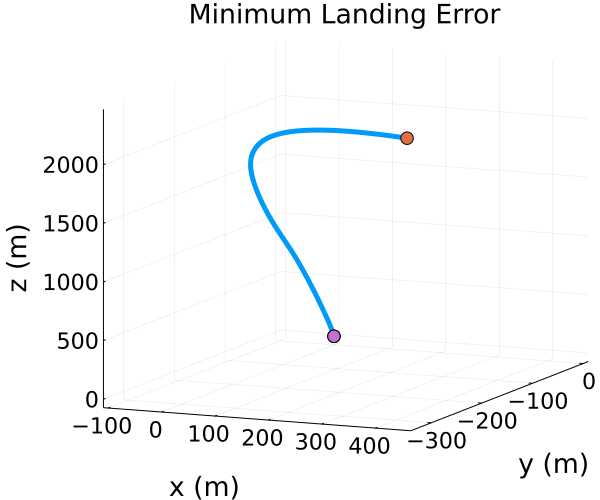

In [55]:
using Plots

Plots.plot(optimal_x[2,:],optimal_x[3,:], optimal_x[1,:], title="Minimum Landing Error",xaxis="x (m)", yaxis="y (m)",zaxis="z (m)", legend=false, 
xtickfontsize=15,ytickfontsize=15,ztickfontsize=15, legendfont=font(15), guidefont=font(18), titlefont = font(18), linewidth=5)
Plots.scatter!([optimal_x[2,1]],[optimal_x[3,1]],[optimal_x[1,1]], markersize=7)
Plots.scatter!([x_goal[2]],[x_goal[3]],[x_goal[1]], label = ["xgoal"], markersize=7)
Plots.scatter!([last(optimal_x[2,:])],[last(optimal_x[3,:])],[last(optimal_x[1,:])], label = ["y"], markersize=7)
plot!(size=(600,500))

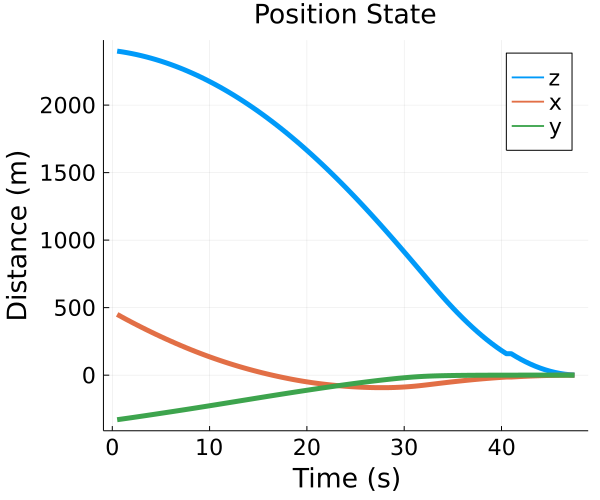

In [56]:
statestime = (1:95)*dt
Plots.plot(statestime, optimal_x[1:3,:]',title="Position State",xaxis="Time (s)", yaxis="Distance (m)", legend=true, label = ["z" "x" "y"], 
    xtickfontsize=15,ytickfontsize=15, legendfont=font(15), guidefont=font(18), titlefont = font(18), linewidth=5)
plot!(size=(600,500))

In [57]:
optimal_x[1:3, 50]

3-element Vector{Float64}:
 1314.2268358237457
  -87.13323314532245
  -60.4220322030861

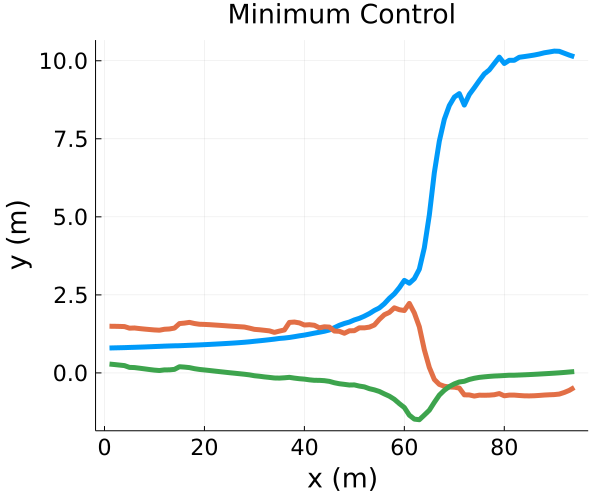

In [59]:
Plots.plot(optimal_u[1:3,:]',title="Minimum Control",xaxis="x (m)", yaxis="y (m)",zaxis="z (m)", legend=false, 
 xtickfontsize=15,ytickfontsize=15, legendfont=font(15), guidefont=font(18), titlefont = font(18), linewidth=5)
plot!(size=(600,500))

In [22]:
xn = [norm(x) for x in eachcol(optimal_u[1:3,:])]

94-element Vector{Float64}:
  1.7184962689033534
  1.716358112329289
  1.7124454328680465
  1.7075787254182553
  1.6590341483440285
  1.6656783142346527
  1.65033115595662
  1.6373517581277997
  1.6268531077864796
  1.6178396769346817
  1.6131685909607165
  1.6437054178426518
  1.6545182231159075
  ⋮
 10.1378357591181
 10.160545239863485
 10.184264745756497
 10.20933171579371
 10.240855523322628
 10.28011077085549
 10.304913665196302
 10.332591343077734
 10.325050819049252
 10.261073683072002
 10.196714602741931
 10.139421412578633

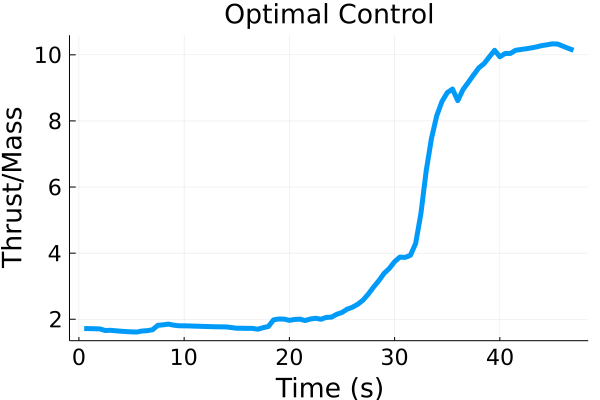

In [68]:
Plots.plot(statestime[1:end-1], xn,title="Optimal Control",xaxis="Time (s)", yaxis="Thrust/Mass",zaxis="z (m)", legend=false
,xtickfontsize=15,ytickfontsize=15, legendfont=font(15), guidefont=font(18), titlefont = font(18), linewidth=5)

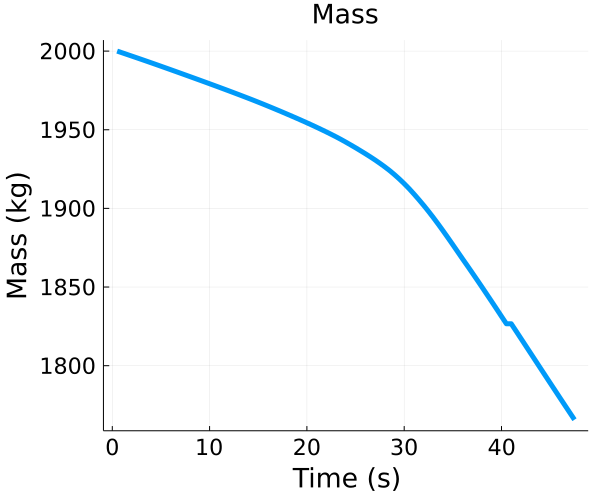

In [69]:
masstime = (1:95)*dt
Plots.plot(masstime,exp.(optimal_x[7,:]),title="Mass",xaxis="Time (s)", yaxis="Mass (kg)",zaxis="z (m)", legend=false, 
xtickfontsize=15,ytickfontsize=15, legendfont=font(15), guidefont=font(18), titlefont = font(18), linewidth=5)
plot!(size=(600,500))

In [70]:
mass_used = exp.(optimal_x[7,1]) - exp.(optimal_x[7,end])

234.34350952940372

In [71]:
#write to a file
using DelimitedFiles
open("positions.txt", "w") do file
        writedlm(file, optimal_x')
    end

open("controls.txt", "w") do file2
        writedlm(file2, optimal_u')
    end

In [72]:
noise_pose = randn(3)*0.001 
noise_velocity = randn(3)*0.001 

3-element Vector{Float64}:
  0.00015022895946343253
 -0.0014593972969660933
 -0.0018781300149052012

In [73]:
state_noise = vec([noise_pose' noise_velocity' 0])'

1×7 adjoint(::Vector{Float64}) with eltype Float64:
 0.00110378  0.000803647  -7.43269e-5  …  -0.0014594  -0.00187813  0.0

In [74]:
Thrust = optimal_u[1:3,:]

3×94 Matrix{Float64}:
 0.798569  0.802583  0.806431  …  10.2419     10.1813     10.1286
 1.495     1.49324   1.48963      -0.626553   -0.559776   -0.466282
 0.283694  0.268314  0.251306      0.0153135   0.0291978   0.0428929

In [75]:
mass = exp.(optimal_x[7,:])

95-element Vector{Float64}:
 1999.9999999999998
 1998.951560537068
 1997.9000942180785
 1996.8451332116106
 1995.7861620897334
 1994.7188605640567
 1993.6464738729694
 1992.566783180662
 1991.4808992185447
 1990.3882036689267
 1989.2908048716492
 1988.1901311077502
 1987.084071223288
    ⋮
 1817.280413072524
 1812.5695624675238
 1807.8540566719835
 1803.1357411262543
 1798.418863045762
 1793.7078644783064
 1789.0046121252042
 1784.3090660007163
 1779.6246246016035
 1774.9546032995668
 1770.300220399027
 1765.656490470596

In [76]:
#re scale the thrust 
N=95
N_thrust = zeros(3, N-1)

for i=1:N-1
    N_thrust[:,i] = Thrust[1:3,i]*mass[i]
end

In [84]:
norm_scaled = xn = [norm(x) for x in eachcol(N_thrust[1:3,:])]/1000

94-element Vector{Float64}:
  3.4369925378067063
  3.4309167270810885
  3.4212948916703882
  3.4097702674271275
  3.3110773956993387
  3.3225599490364046
  3.290176889795617
  3.2625327256279117
  3.2398468899911026
  3.220129008398338
  3.2090614447059083
  3.2679988902031014
  3.2876668067022776
  ⋮
 18.471014235910168
 18.46455985054118
 18.459688294269284
 18.4569817583076
 18.465652613813244
 18.487945124506425
 18.484004684032577
 18.485053567971022
 18.423081783347705
 18.260859401246407
 18.098705522668705
 17.94981996140657

In [85]:
time = (1:94)*dt

0.5:0.5:47.0

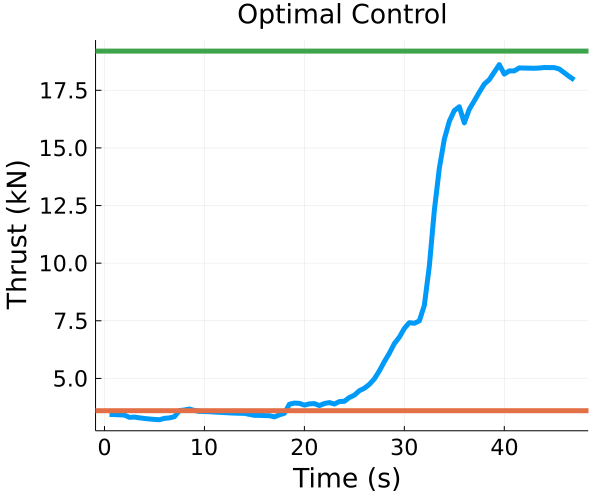

In [87]:
Plots.plot(time,norm_scaled,title="Optimal Control",xaxis=" Time (s)", yaxis="Thrust (kN)", legend=false, 
xtickfontsize=15,ytickfontsize=15, legendfont=font(15), guidefont=font(18), titlefont = font(18), linewidth=5)
#Plots.plot!(Vector[[4800,19200]], linetype=[:hline, :hline], widths=[10, 10])
Plots.plot!([3600/1000], linetype=:hline, width=5)
Plots.plot!([19200/1000], linetype=:hline, width=5)
plot!(size=(600,500))

In [ ]:
optimal_x[4:6,end]

In [ ]:
norm_scaled[25]

In [ ]:
optimal_u[4,1]

In [13]:
log(300)

5.703782474656201